# Pittsburgh's Public Transportation: Exploring Time Series Data and Visualization
## Author: Hexing Ren
### Click [here](http://www.hexingren.com/practical-data-science) to go back.

# Introduction

In this project we will be analysing time series data. Specifically, the data that we will be working with has been collecting via Pittsburgh's TrueTime system which is available publicly here http://truetime.portauthority.org/bustime/login.jsp.

## Part 1 The TrueTime Dataset

The bus data has been collected by querying the TrueTime API every minute. Each time, we make two requests: 

1. We request vehicle information for every bus running on the 61A, 61B, 61C, and 61D bus routes. 
2. We request all available time predictions for the CMU / Morewood bus stop in both outbound and inbound directions. 

The results are given as XML, which are consequently parsed and stored within a sqlite database with two tables, one for vehicles and one for predictions. The table for the vehicles is organized in the following manner.  

| | **vehicles**             | 
|----------|-------------|
| vid      | vehicle identifier |
| tmstmp | date and time of the last positional update of the vehicle |
| lat | latitude position of the vehicle in decimal degrees |
| lon | longitude position of the vehicle in decimal degrees |
| hdg | heading of vehicle as a 360 degree value (0 is north, 90 is east, 180 is south, and 270 is west |
| pid | pattern ID of trip currently being executed | 
| rt | route that is currently being execute | 
| des | destination of the current trip | 
| pdist | linear distance (feet) vehicle has traveled into the current pattern |
|  spd | speed as reported from the vehicle in miles per hour | 
| tablockid | TA's version of the scheduled block identifier for work currently behind performed |
| tatripid | TA's version of the scheduled trip identifier for the vehicle's current trip |

The table for the predictions is organized in the following manner

| | **predictions** | 
|---|---|
| tmstmp | date and time the prediction was generated |
| typ | type of prediction (A for arrival, D for a departure) | 
| stpnm | display name of the stop for which this prediction was generated |
| stpid | unique identifier representing the stop for which this prediction was generated |
| vid | unique ID of the vehicle for which this prediction was generated |
| dstp | linear distance (feet) left to be traveled by the vehicle before it reaches the stop for which this prediction was generated |
| rt | route for which this prediction was generated | 
| rtdd | language-specific route designator meant for display |
| rtdir | direction of travel of the route associated with this prediction |
| des | final destination of the vehicle associated with this prediction |
| prdtm | predicted date and time of a vehicle's arrival or departure to the stop associated with this prediction | 
| dly | true if the vehicle is delayed, only present if the vehicle that generated this prediction is delayed | 
| tablockid | TA's version of the scheduled block identifier for work currently behind performed |
| tatripid | TA's version of the scheduled trip identifier for the vehicle's current trip |
    

First we will need to read in the data. Since the raw form of the data has been dumped into a sqlite database, we can read them directly into a pandas dataframe. However, we still need to fix and canonicalize a few things.

### Specification

1. Sometimes the TrueTime API returns a bogus result that has all the attributes but empty strings for all the values. We should inspect the data for clearly useless entries and remove all offending rows. 

2. If we check the datatype of each column, we'll notice that most columns are stored as objects. However, some of these columns are in fact integers or floats, and if we want to run numerical functions on them (like numpy) we'll need to convert the columns to the correct type. Note that strings show up as objects. This is because the underlying implementation of Pandas uses numpy arrays, which need fixed-size entries, so they store pointers to strings. The dataframe datatypes should match the following order and types (the datatypes may be 32bit instead of 64bit depending on the platform):

   ```python
   >>> vdf.dtypes
   vid                   int64
   tmstmp       datetime64[ns]
   lat                 float64
   lon                 float64
   hdg                   int64
   pid                   int64
   rt                   object
   des                  object
   pdist                 int64
   spd                   int64
   tablockid            object
   tatripid              int64
   dtype: object

   >>> pdf.dtypes
   tmstmp       datetime64[ns]
   typ                  object
   stpnm                object
   stpid                 int64
   vid                   int64
   dstp                  int64
   rt                   object
   rtdd                 object
   rtdir                object
   des                  object
   prdtm        datetime64[ns]
   dly                    bool
   tablockid            object
   tatripid              int64
   dtype: object
   ```

3. As you may have noticed from the above data types, you should convert all timestamps to Pandas datetime objects. 

In [1]:
import pandas as pd
import sqlite3

In [2]:
def load_data(fname):
    """ Read the given database into two pandas dataframes. 
    
    Args: 
        fname (string): filename of sqlite3 database to read
        
    Returns:
        (pd.DataFrame, pd.DataFrame): a tuple of two dataframes, the first for the vehicle data and the 
                                      second for the prediction data. 
    """
    conn = sqlite3.connect(fname)
    vdf = pd.read_sql_query("SELECT * FROM vehicles WHERE vid != ''", conn)
    vdf['vid'] = vdf['vid'].astype('int')
    vdf['tmstmp'] = pd.to_datetime(vdf['tmstmp'])
    
    pdf = pd.read_sql_query("SELECT * FROM predictions WHERE tmstmp != ''", conn)
    pdf['tmstmp'] = pd.to_datetime(pdf['tmstmp'])
    pdf['prdtm'] = pd.to_datetime(pdf['prdtm'])
    pdf['dly'] = pdf['dly'].astype('bool')
    conn.close()
    return (vdf, pdf)

In [3]:
# AUTOLAB_IGNORE_START
vdf, pdf = load_data('bus_aug23.db')

# print len(vdf), len(pdf)
# print vdf.iloc[:200, :12]

# Inspect the datatypes of the dataframe
print vdf.dtypes
print pdf.dtypes

print len(vdf), len(pdf)

# Inspect the first five entries of the dataframe
print vdf.head()
print pdf.head()
# AUTOLAB_IGNORE_STOP

vid                   int64
tmstmp       datetime64[ns]
lat                 float64
lon                 float64
hdg                   int64
pid                   int64
rt                   object
des                  object
pdist                 int64
spd                   int64
tablockid            object
tatripid              int64
dtype: object
tmstmp       datetime64[ns]
typ                  object
stpnm                object
stpid                 int64
vid                   int64
dstp                  int64
rt                   object
rtdd                 object
rtdir                object
des                  object
prdtm        datetime64[ns]
dly                    bool
tablockid            object
tatripid              int64
dtype: object
215473 143345
    vid              tmstmp        lat        lon  hdg   pid   rt        des  \
0  5549 2016-08-11 10:56:00  40.439504 -79.996981  114  4521  61A  Swissvale   
1  5287 2016-08-11 10:56:00  40.438016 -79.927380   83  4521  61A  Swi

## Part 2 Splitting Trips

For this task, we will focus on the vehicles dataframe and come back to the predictions later. The next thing we will do is take the dataframe of vehicles and and split it into individual trips. Specifically, a trip is the sequence of rows corresponding to a single bus, typically at one minute intervals, from the start of its route to the end of its route. We will represent each trip as an individual dataframe, and create a list of dataframes for each trip. 

### Specification
1. All entries in a trip should belong to a single route, destination, pattern, and bus. 

2. The entries in a trip should have (not strictly) monotonically increasing timestamps and distance traveled. 

3. Each trip should be of maximal size. I.e. we should sort first by time, and secondarily by pdist, and use a drop in a pdist as an indication that a new trip has started. 

3. Each trip should have the timestamp set as the index, named `tmstmp`

In [4]:
def split_trips(df):
    """ Splits the dataframe of vehicle data into a list of dataframes for each individual trip.

    Args:
        df (pd.DataFrame): A dataframe containing TrueTime bus data

    Returns:
        (list): A list of dataframes, where each dataFrame contains TrueTime bus data for a single bus running a
    """
# AUTOLAB_IGNORE_START 
# spec1: a single route, destination, pattern, and bus
# AUTOLAB_IGNORE_STOP
    df.sort_values(by=['rt', 'des', 'pid', 'vid', 'tmstmp'], ascending=True, inplace=True)
    trips = list()
# AUTOLAB_IGNORE_START 
# start
# AUTOLAB_IGNORE_STOP
    s = 0
    start = df.iloc[0]
    prev_vid, prev_pid, prev_rt, prev_des, prev_pdist = start['vid'], start['pid'], start['rt'], start['des'], start['pdist']
    
    for i in range(len(df.index)):
        pres = df.iloc[i]
        pres_vid, pres_pid, pres_rt, pres_des, pres_pdist = pres['vid'], pres['pid'], pres['rt'], pres['des'], pres['pdist']
# AUTOLAB_IGNORE_START         
#         if pres_pdist < prev_pdist:
# AUTOLAB_IGNORE_STOP
        if pres_vid != prev_vid or pres_pid != prev_pid or pres_rt != prev_rt or pres_des != prev_des or \
        pres_pdist < prev_pdist:
            trip_df = df[s:i]
            trips.append(trip_df)
            s = i

        prev_vid, prev_pid, prev_rt, prev_des, prev_pdist = pres_vid, pres_pid, pres_rt, pres_des, pres_pdist
    
    trip_df = df[s:]
    trips.append(trip_df)
    
    return trips

# AUTOLAB_IGNORE_START    
all_trips = { rt : split_trips(vdf[vdf["rt"]==rt]) for rt in ["61A", "61B", "61C", "61D"] }
# AUTOLAB_IGNORE_STOP

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Test the validity of your code here
# AUTOLAB_IGNORE_START
# print [(t,len(all_trips[t])) for t in all_trips]
# AUTOLAB_IGNORE_STOP

## Part 3 Sliding Averages

Let's compute a basic statistic for time series / sequential data, which is the sliding average. Sliding averages are typically used to smooth out short-term fluctuations to see the long-term patterns. 

While it would be fairly simple to directly construct a list of all the sliding averages from the existing dataset, in reality, new TrueTime bus data is constantly being available every day. Thus, instead of storing an unbounded list of datapoints, we instead will construct a class which does constant time updates as new data comes in. 

### Specifications
1. The function should not use more than O(k) memory. 
2. Each update should do O(1) work. 
3. We will use a centered sliding average: we will average the k values both before and after, averaging a total of 2k+1 elements. Note that k=0 will just return the stream without any averaging. 
4. Since the average depends on both past and future elements, the `update` function will not be able to output anything useful for the first k elements. We should output `None` during these iterations. We should also signify the end of the stream by calling `update(None)` k times, during which we output the last k sliding averages. 
4. When at the beginning or end of a list, just compute the average of elements that exist. 
5. As usual, we should test the correctness of the code. We can do this in the same cell or make a new cell.

Note: the `collections.deque` data structure might be helpful. 

Example: 
```python
>>> compute_sliding_averages(pd.Series([1,2,3,4,5]),1)
pdf.Series([1.5, 2.0, 3.0, 4.0, 4.5])
```

In [6]:
from collections import deque

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements.

        Args:
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.avg = 0
        self.cnt = -1
        self.half_width = k
        self.width = 2 * k + 1
        self.queue = deque()

    def update(self,x):

        """ Computes the sliding average after having seen element x

        Args:
            x (float): the next element in the stream to view

        Returns:
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        self.cnt = self.cnt + 1
        prevlen = len(self.queue)
        
        if x != None:
            self.queue.append(float(x))
            if self.cnt >= self.width:
                self.avg = (prevlen * self.avg - self.queue.popleft() + float(x)) / prevlen
                return self.avg
            elif self.cnt >= self.half_width:
                self.avg = (prevlen * self.avg + float(x)) / (prevlen + 1)
                return self.avg
            else:
                self.avg = (prevlen * self.avg + float(x)) / (prevlen + 1)
                return None
        else:
            if self.cnt >= self.width:
                self.avg = (prevlen * self.avg - self.queue.popleft()) / (prevlen - 1)
                return self.avg
            elif self.cnt >= self.half_width:
                return self.avg
            else:
                return None
    
def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class.

    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window

    Returns:
        (pd.Series): a Pandas series of the sliding averages

    """
    sAvg = SlidingAverage(k)
    l = list()
    
    for si in s:
        avg = sAvg.update(si)
        if avg != None:
            l.append(avg)
    for i in range(k):
        avg = sAvg.update(None)
        if avg != None:
            l.append(avg)
    
    return pd.Series(l)  

# Test the code!
# print(compute_sliding_averages(pd.Series([1,2,3,4,5]),6))

## Part 4 Time Series Visualizations

Time series data is typically displayed as signals over time. For example, this could be the speed of the bus over time, or the number of minutes behind or ahead of schedule a bus is. 

In [7]:
import time
import matplotlib
# Use svg backend for better quality
# AUTOLAB_IGNORE_START
matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen
# AUTOLAB_IGNORE_STOP

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


As the first example, we'll plot the speed of the bus as a function of time. Here, we'll overlay multiple routes on a single plot. How can we determine the direction of the bus (to or away from downtown) from the signal? 

### Specification:
1. Plot the sliding average speed of each bus, using a new line for each bus. 
2. Return a list of the resulting `Line2D` objects plot. The order of the line objects should correspond with the order of the trips. 
3. Do not call `plt.show()` inside the function. Autolab will not X out of any plotted images. 
4. We want to plot the bus as a function of time, and not of datetime (these are different python types) which is the index of the dataframe. We can get the time with df.index.time. 

In [8]:
def plot_trip(trips, k):
    """ Plots the sliding average speed as a function of time 
    
    Args: 
        trip (list): list of trip DataFrames to plot
        k (int): the half-width of the sliding average window
    """
    
    l = list()
    for trip in trips:
        trip = trip.reset_index()
        t = [tt.time() for tt in trip['tmstmp']]
        spd = (compute_sliding_averages(trip['spd'], k)).tolist()
        l.append(matplotlib.lines.Line2D(t, spd))
    return l

# AUTOLAB_IGNORE_START   
# Play around with these values. Can you differentiate the buses going towards downtown from the buses going away from downtown?
lines = plot_trip(all_trips['61A'][:20], 15)
print(lines)
plt.show()
# AUTOLAB_IGNORE_STOP

[<matplotlib.lines.Line2D object at 0x122348490>, <matplotlib.lines.Line2D object at 0x1223487d0>, <matplotlib.lines.Line2D object at 0x122348910>, <matplotlib.lines.Line2D object at 0x122348b10>, <matplotlib.lines.Line2D object at 0x122348d50>, <matplotlib.lines.Line2D object at 0x122348f90>, <matplotlib.lines.Line2D object at 0x121c96210>, <matplotlib.lines.Line2D object at 0x121c96450>, <matplotlib.lines.Line2D object at 0x121c96690>, <matplotlib.lines.Line2D object at 0x121c968d0>, <matplotlib.lines.Line2D object at 0x121c96b10>, <matplotlib.lines.Line2D object at 0x121c96d50>, <matplotlib.lines.Line2D object at 0x121c96f90>, <matplotlib.lines.Line2D object at 0x121b16210>, <matplotlib.lines.Line2D object at 0x121b16450>, <matplotlib.lines.Line2D object at 0x121b16690>, <matplotlib.lines.Line2D object at 0x121b168d0>, <matplotlib.lines.Line2D object at 0x121b16b10>, <matplotlib.lines.Line2D object at 0x121b16d50>, <matplotlib.lines.Line2D object at 0x121b16f90>]


We can also gain information from overall trends from averaging many data points. In the following function, we will plot the average speed of all buses at regular time intervals throughout the day. 

### Specification
1. We should group the rows of the dataframe by taking the timestamp and subtracting its value modulo t minutes and ignoring the day/month/year (since the data was collected at 1 minute intervals, this means that t=1 corresponds to averaging one entry per day recorded).
2. Return the PathCollection object of the plot. For example, if we create the plot using the matplotlib command `scatter(...)`, return the result of this function call. 
3. Do not call `plt.show()` inside the function. Autolab will not X out of any plotted images. 

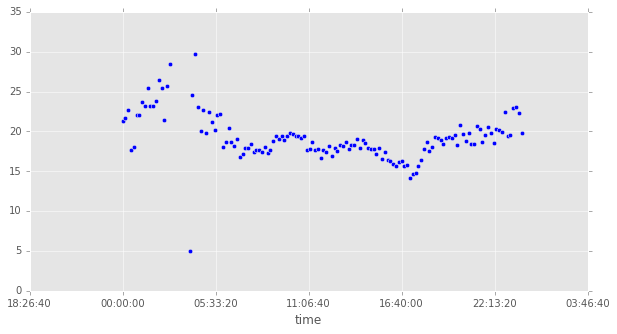

In [9]:
import datetime

def plot_avg_spd(df, t):
    """ Plot the average speed of all recorded buses within t minute intervals 
    Args: 
        df (pd.DataFrame): dataframe of bus data
        t (int): the granularity of each time period (in minutes) for which an average is speed is calculated
    """
    df['tmmin'] = df['tmstmp'].map(lambda i : (60 * i.hour + i.minute) / t)
    df = df.reset_index()
    spd_df = df.groupby('tmmin').mean()
    tmin = [datetime.time(t * j / 60, t * j % 60) for j in spd_df.index.tolist()]
    return plt.scatter(tmin, spd_df['spd'].tolist())

# AUTOLAB_IGNORE_START
s = plot_avg_spd(vdf, 10)
plt.show()
# AUTOLAB_IGNORE_STOP

## Author: Hexing Ren
### Click [here](http://www.hexingren.com/practical-data-science) to go back.